In [1]:
from copy import deepcopy
import tqdm.notebook

import jax.numpy as jnp
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

from adaptive_mcmc.distributions.distribution import GaussianMixture, FunnelDistribution, Gaussian
from adaptive_mcmc.samplers import (
    base_sampler,
    # mala,
    # fishermala,
    hmc,
    hmcadaptive,
)
from adaptive_mcmc.samplers.stopping_rule import NoStop
from adaptive_mcmc.tools.benchmark import BenchmarkUtils
from adaptive_mcmc.tools.metrics import compute_ess, compute_emd

from typing import Tuple, Optional

2025-05-23 02:49:48.906073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747957788.916411   20481 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747957788.919433   20481 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
seed = 123
torch.manual_seed(seed)

device = "cpu"

hparams = {
    # "mala": mala.MALAParams(
    #     sigma=1.0,
    #     sigma_lr=0.015,
    #     target_acceptance=0.574,
    #     device=device,
    # ),
    # "fisher_mala": fishermala.FisherMALAParams(dampening=10.),
    "hmc_vanilla": {
        "common": hmc.HMCCommonParams(
            lf_step_count=50,
            lf_step_size=5e-2,
            lf_step_size_max=5e-1,
        ),
        "fixed": hmc.HMCFixedParams(no_grad=True, stop_grad=False),
    },
    "taylor_nograd": {
        "common": hmcadaptive.HMCAdaptiveCommonParams(
            lf_step_count=50,
            lf_step_size=5e-2,
            lf_step_size_max=5e-1,
            learning_rate=3e-4,
            truncation_level_prob=0.5,
            min_truncation_level=2,
            entropy_weight=1e-1,
            entropy_weight_min=1e-3,
            entropy_weight_max=1e2,
            penalty_weight_max=1e1,
            penalty_weight=1e-3,
            penalty_weight_adaptive_rate=1e-3,
            clip_grad_value=1e1,
        ),
        "fixed": hmcadaptive.HMCAdaptiveFixedParams(
            prec_init_scale=1e-9,
            no_grad=True,
            stop_grad=False,
            backprop_method="approx",
            prec_type="tridiag",
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
    },
    "lanczos_nograd": {
        "common": hmcadaptive.HMCAdaptiveCommonParams(
            lf_step_count=50,
            lf_step_size=5e-2,
            lf_step_size_max=5e-1,
            learning_rate=3e-4,
            entropy_weight=1e-1,
            entropy_weight_min=1e-3,
            entropy_weight_max=1e2,
            clip_grad_value=1e1,
            lanczos_steps=8,
            krylov_probe_vectors=1,
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
        "fixed": hmcadaptive.HMCAdaptiveFixedParams(
            prec_init_scale=1e-9,
            no_grad=True,
            stop_grad=False,
            backprop_method="approx",
            prec_type="tridiag",
            trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
    },
    # "hmcadaptive_hutch_taylor": {
    #     "common": hmcadaptive.HMCAdaptiveCommonParams(
    #         lf_step_count=25,
    #         lf_step_size=0.1,
    #         learning_rate=1e-3,
    #         truncation_level_prob=0.5,
    #         min_truncation_level=2,
    #         entropy_weight=1e-1,
    #         entropy_weight_min=1e-3,
    #         entropy_weight_max=1e2,
    #         penalty_weight_max=1e1,
    #         penalty_weight=1e-3,
    #         penalty_weight_adaptive_rate=1e-3,
    #         clip_grad_value=1e1,
    #     ),
    #     "fixed": hmcadaptive.HMCAdaptiveFixedParams(
    #         prec_init_scale=1e-1,
    #         no_grad=False,
    #         stop_grad=False,
    #         prec_type="tridiag",
    #         # iter_count=10000,
    #         # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    #     ),
    # },
    # "hmcadaptive_hutch_lanczos": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-2,
    #     entropy_weight=1e-1,
    #     entropy_weight_min=1e-3,
    #     entropy_weight_max=1e2,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
    #     lanczos_steps=4,
    #     krylov_probe_vectors=1,
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
    # "hmcadaptive_noent": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-4,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     entropy_method="none",
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
    # "hmcadaptive_fullent": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-2,
    #     entropy_weight=1e-1,
    #     entropy_weight_min=1e-3,
    #     entropy_weight_max=1e2,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
    #     lanczos_steps=4,
    #     krylov_probe_vectors=1,
    #     entropy_method="full",
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
}

In [3]:
def get_random_GM(
    gaussian_count: int,
    dimension: int,
    cube: float,
    eps: float=5e-1,
    scale: float=5.,
):
    true_means = torch.rand((gaussian_count, dimension)) * cube - cube / 2
    scales = torch.rand((gaussian_count, dimension)) * scale

    while True:
        try:
            true_covs = torch.rand((gaussian_count, dimension, dimension))
            true_covs, _ = torch.linalg.qr(true_covs)
        
            true_covs = (
                true_covs @ torch.diag_embed(scales) @ true_covs.permute(0, 2, 1) 
                + eps * torch.eye(dimension).unsqueeze(0)
            )
            
            # true_covs = (
            #     true_covs @ true_covs.permute(0, 2, 1) +
            #     torch.eye(dimension).repeat(gaussian_count, 1, 1)
            # )
        
            gm = GaussianMixture(
                true_means,
                true_covs,
                torch.full((gaussian_count,), 1/gaussian_count, dtype=torch.float64)
            )
            break
        except ValueError:
            pass
            
    return gm, true_means

In [4]:
def get_random_GM(
    gaussian_count: int,
    dimension: int,
    cube: float,
    eps: float = 5e-1,
    scale: float = 1.0,
    *,
    seed: Optional[int] = None,
    device: torch.device | str = "cpu",
    dtype: torch.dtype = torch.float32,
) -> Tuple[GaussianMixture, torch.Tensor]:
    """
    Create a reproducible random Gaussian Mixture.

    Parameters
    ----------
    gaussian_count : int      # number of components
    dimension      : int      # dimensionality
    cube           : float    # component means ∈ (-cube/2, cube/2)
    eps            : float    # ε·I added to each covariance
    scale          : float    # upper–bound on random eigen-scales
    seed           : int|None # RNG seed for reproducibility
    device         : str|torch.device
    dtype          : torch.dtype

    Returns
    -------
    gm          : GaussianMixture
    true_means  : Tensor (gaussian_count, dimension)
    """
    g = torch.Generator(device=device)
    if seed is not None:
        g.manual_seed(seed)

    true_means = (
        torch.rand((gaussian_count, dimension), generator=g, device=device, dtype=dtype)
        * cube - cube/2
    )

    scales = torch.rand((gaussian_count, dimension), generator=g, device=device, dtype=dtype) * scale

    while True:
        try:
            # Q = torch.rand((gaussian_count, dimension, dimension), generator=g, device=device, dtype=dtype)
            # Q, _ = torch.linalg.qr(Q)
            Q_list = []
            for _ in range(gaussian_count):
                q = torch.randn((dimension, dimension), generator=g, device=device, dtype=dtype)
                q, _ = torch.linalg.qr(q)
                Q_list.append(q)
            
            Q = torch.stack(Q_list, dim=0)  # shape: (gaussian_count, dimension, dimension)


            true_covs = (
                Q @ torch.diag_embed(scales) @ Q.transpose(-1, -2)
                + eps * torch.eye(dimension, device=device, dtype=dtype).unsqueeze(0)
            )

            gm = GaussianMixture(
                true_means,
                true_covs,
                torch.full((gaussian_count,), 1.0 / gaussian_count, device=device, dtype=dtype),
            )
            break
        except ValueError:
            continue

    return gm, true_means

In [5]:
def generate_simplex(d: int) -> torch.Tensor:
    I = torch.eye(d)
    
    ones = torch.ones((d, d)) / (d+1)
    v1d = I - ones
    vdp1 = -torch.ones((1, d)) / (d+1)
    return torch.cat([v1d, vdp1], dim=0)


def get_toeplitz_GM(dimension: int, cube: float, rho: float=0.99, sigma: float=1.):
    true_means = generate_simplex(dimension) * cube

    inds = torch.arange(dimension)
    power = torch.abs(inds.unsqueeze(0) - inds.unsqueeze(1))

    true_covs = sigma ** 2 * rho ** power
    true_covs = true_covs.repeat(dimension + 1, 1, 1)

    gm = GaussianMixture(
        true_means,
        true_covs,
        torch.ones(dimension + 1) / (dimension + 1)
    )

    return gm, true_means


def get_toeplitz_gaussian(dimension: int,
                          mean: float = None,
                          rho: float = 0.99,
                          sigma: float = 1.0) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
        
    inds = torch.arange(dimension)
    power = torch.abs(inds.unsqueeze(0) - inds.unsqueeze(1))
    cov = (sigma ** 2) * (rho ** power)
    
    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)


def get_illcond_gaussian(dimension: int,
                         mean: float = None,
                         min_v: float = 1e-2,
                         max_v: float = 1e2) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
    elif isinstance(mean, (float, int)):
        mean = torch.full((dimension,), float(mean))
    else:
        mean = torch.tensor(mean, dtype=torch.float32)

    # Create log-spaced eigenvalues (ill-conditioned spectrum)
    eigvals = torch.logspace(torch.log10(torch.tensor(min_v)), 
                             torch.log10(torch.tensor(max_v)), 
                             steps=dimension)

    # Construct diagonal covariance matrix
    cov = torch.diag(eigvals)

    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)
    

def sample_se_covariance_torch(dimension, scale=4., noise=0.01, seed=None, device='cpu'):
    if seed is not None:
        torch.manual_seed(seed)

    x = torch.linspace(0, scale, dimension)

    x1 = x.unsqueeze(1)
    x2 = x.unsqueeze(0)
    dist_squared = (x1 - x2) ** 2

    K = torch.exp(-0.5 * dist_squared / (0.1 * scale**2))

    K += noise * torch.eye(dimension, device=device)

    return x, K
    
def get_deterministic_gaussian_se(dimension: int,
                                  mean: float = None,) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
        
    _, cov = sample_se_covariance_torch(dimension)
    
    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)

In [6]:
# dist = FunnelDistribution(32, scale=3)

#dist, _ = get_toeplitz_gaussian(256, rho=0.95)
# dist, _ = get_deterministic_gaussian_se(32)
dist, _ = get_illcond_gaussian(128)

# dist, _ = get_random_GM(gaussian_count=25, dimension=32, cube=2., scale=2.,)
# dist, _ = get_toeplitz_GM(dimension=32, cube=2., rho=0.9)


samples = dist.sample(5000).detach().numpy()

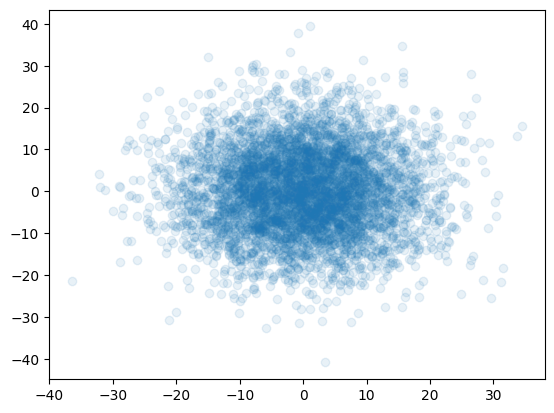

In [7]:
plt.scatter(samples[:, -2], samples[:, -1], alpha=0.1)

In [8]:
def dist_factory(name, dimension, cube=2., scale=2., funnel_scale=3, gaussian_count=25, rho=0.95, sigma=1.,
                 min_v=1e-2, max_v=1e2,
                ):
    if name == "random_gm":
        return get_random_GM(gaussian_count=gaussian_count, dimension=dimension, cube=cube, scale=scale)
    elif name == "toeplitz_gm":
        return get_toeplitz_GM(dimension, cube=cube, rho=rho, sigma=sigma)
    elif name == "toeplitz_gaussian":
        return get_toeplitz_gaussian(dimension, rho=rho, sigma=sigma)
    elif name == "deterministic_gaussian_se":
        return get_deterministic_gaussian_se(dimension)
    elif name == "funnel":
        return FunnelDistribution(dimension, scale=funnel_scale), torch.zeros(1, dimension)
    elif name == "illcond_gaussian":
        return get_illcond_gaussian(dimension, min_v=min_v, max_v=max_v)

In [9]:
import pandas as pd
from scipy.stats import norm
from itertools import combinations


def drop_static_chains(samples: torch.Tensor, eps: float = 0.0):
    var_per_chain = samples.var(dim=0, unbiased=False)

    static = (var_per_chain <= eps).all(dim=-1)
    keep_mask = ~static

    return samples[:, keep_mask, :], keep_mask.sum().item()


def z_test(dim_stat):
    all_results = {}
    for dim, df in dim_stat.items():
        recs = []
        algs = df.columns
        for A, B in combinations(reversed(algs), 2):
    
            mA, sA = df.loc['ess_mean', A], df.loc['ess_conf_sigma', A]
            mB, sB = df.loc['ess_mean', B], df.loc['ess_conf_sigma', B]
            z_ess = (mA - mB) / (sA**2 + sB**2)**0.5
            p_ess = norm.sf(z_ess)
    
            tA, seA = df.loc['tv_mean', A], df.loc['tv_conf_sigma', A]
            tB, seB = df.loc['tv_mean', B], df.loc['tv_conf_sigma', B]
            z_tv = (tB - tA) / (seA**2 + seB**2)**0.5
            p_tv = norm.sf(z_tv)
            recs.append({
                'alg_A': A, 'alg_B': B,
                'z(ESS_A>B)': z_ess, 'p(ESS_A>B)': p_ess,
                'z(TV_A<B)': z_tv,  'p(TV_A<B)': p_tv,
            })
        all_results[dim] = pd.DataFrame.from_records(recs)
    return all_results


def compute_results(hist_data, algs, dist_name=None):
    dim_stat = {}

    for dimension in tqdm.notebook.tqdm(dimensions, desc="dimension"):
        rows = []
        for alg in tqdm.notebook.tqdm(algs, desc="alg", leave=False):
            obj = hist_data[dimension][alg]
            cache = obj["cache"]
            pure_runtime = obj["pure_runtime"]
    
            clean_samples, n_kept = drop_static_chains(cache.samples)
    
            metrics = BenchmarkUtils.compute_metrics(clean_samples,
                                                     cache.true_samples)
            metrics["runtime"]      = pure_runtime
            metrics["chains_kept"]  = n_kept
            rows.append(metrics)
    
        df = pd.DataFrame(rows, index=list(algs.keys())).T
        dim_stat[dimension] = df
        print(f"\ndim={dimension}, dist={dist_name}\n", df)
        print(z_test(dim_stat))
    
    return dim_stat

In [10]:
def run_experiment(dist_name, log=[]):
    hist_data = {}
    runtime = {
        dimension: dict()
        for dimension in dimensions
    }
    pure_runtime = deepcopy(runtime)
    distance_to_mass_points = 1.
    
    for dimension in tqdm.notebook.tqdm(dimensions):
        print("Processing dimension", dimension)
        hist_data[dimension] = {}
        target_dist, true_means = dist_factory(dist_name, dimension)
        
        # target_dist, true_means = get_random_GM(gaussian_count, dimension, cube)
        # gm, true_means = get_deterministic_GM(dimension, cube)
        # true_samples = gm.sample(sample_count)
    
        # target_dist = FunnelDistribution(dimension, scale=scale)
        
        # target_dist, _ = get_deterministic_gaussian(dimension, rho=0.8)
        # target_dist, _ = get_deterministic_gaussian_se(dimension)
    
        # true_means = torch.zeros(1, dimension)
        true_samples = target_dist.sample(sample_count)
        
        starting_points = BenchmarkUtils.generate_starting_points(
            chain_count, dimension,
            true_means,
            distance_to_mass_points,
        )
    
        common_params = base_sampler.CommonParams(
            target_dist=target_dist,
            starting_point=starting_points.clone(),
            proposal_dist=torch.distributions.MultivariateNormal(
                torch.zeros(dimension, device=device),
                torch.eye(dimension, device=device),
            ),
        )
    
        for alg in algs:
            print("-" * 80)
            base_meta_adj = hparams[alg]["common"].copy_update(common_params)
            if hasattr(base_meta_adj, "sigma"):
                base_meta_adj.sigma /= dimension
    
            algs[alg].load_params(base_meta_adj)
            algs[alg].load_true_samples(true_samples)
            algs[alg].run()
    
            hist_data[dimension][alg] = {
                "cache": algs[alg].pipeline.sample_blocks[-1].iteration.cache,
                "stop_data_hist": algs[alg].pipeline.sample_blocks[-1].stop_data_hist,
                "runtime": algs[alg].pipeline.runtime,
                "pure_runtime": algs[alg].pipeline.pure_runtime,
            }
        print()

    dim_stat = compute_results(hist_data, algs, dist_name)
    log.append({
        "hist_data": hist_data,
        "algs": algs,
        "dist_name": dist_name,
        "dim_stat": dim_stat,
    })

In [11]:
def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

def print_log(log):
    for entry in log:
        for dimension in dimensions:
            print(f"\ndim={dimension}, dist={entry['dist_name']}\n", entry["dim_stat"][dimension])

In [12]:
chain_count = 30
sample_count = 5000
sample_iter_limit = 5000
burn_in_iter_count = 5000
step_size_burn_in_iter_count = 2500
probe_period = 250000

tv_threshold = 0.05
tail_count_cap = 1000
# stopping_rule = TVStop(threshold=tv_threshold, density_probe_count=1000,
#                        projection_count=25, tail_count_cap=tail_count_cap)

stopping_rule = NoStop(
    density_probe_count=500,
    projection_count=25,
    tail_count_cap=tail_count_cap,
)


dist_names = [
    #"toeplitz_gm",
    "toeplitz_gaussian",
    "funnel",
    "random_gm",
    "illcond_gaussian",
]

dimensions = [8, 16, 32, 64, 128, 256]
log = []

for dist_name in dist_names:
    algs = {
        # "mala": mala.MALAVanilla(
        #     pipeline=None,
        #     name="MALA",
        #     sigma_burn_in_params=hparams["mala"].copy(),
        #     sigma_burn_in_iter_count=burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        # "fisher_mala": fishermala.FisherMALAVanilla(
        #     pipeline=None,
        #     name="FisherMALA",
        #     sigma_burn_in_params=hparams["fisher_mala"].copy(),
        #     sigma_burn_in_iter_count=500,
        #     prec_burn_in_params=hparams["fisher_mala"].copy(),
        #     prec_burn_in_iter_count=burn_in_iter_count - 500,
        #     sample_iter_count=sample_iter_limit,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        "hmc_vanilla": hmc.HMCVanilla(
            pipeline=None,
            name="HMCVanilla",
            common_params=hparams["hmc_vanilla"]["common"].copy(),
            fixed_params=hparams["hmc_vanilla"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
        ),
        "taylor_nograd": hmcadaptive.HMCAdaptive(
            pipeline=None,
            name="HMCAdaptiveHutchTaylorNoGrad",
            common_params=hparams["taylor_nograd"]["common"].copy(),
            fixed_params=hparams["taylor_nograd"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
        ),
        "lanczos_nograd": hmcadaptive.HMCAdaptive(
            pipeline=None,
            name="HMCAdaptiveHutchLanczosNoGrad",
            common_params=hparams["lanczos_nograd"]["common"].copy(),
            fixed_params=hparams["lanczos_nograd"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
        ),
        # "hmcadaptive_hutch_taylor": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveHutchTaylor",
        #     common_params=hparams["hmcadaptive_hutch_taylor"]["common"].copy(),
        #     fixed_params=hparams["hmcadaptive_hutch_taylor"]["fixed"],
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        # "hmcadaptive_fullent": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveFullEnt",
        #     params=hparams["hmcadaptive_fullent"].copy(),
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        # "hmcadaptive_noent": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveNoEnt",
        #     params=hparams["hmcadaptive_noent"].copy(),
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
    }
    run_experiment(dist_name, log=log)

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dimension 8
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.25448864698410034
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.25448864698410034
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.25545090436935425
max_step_size=0.5
broken_traj=0
Runtime: 162.93s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.25361916422843933
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.25361916422843933
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49976545572280884
max_step_size=0.5
broken_traj=0
Runtime: 250.19s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.25702276825904846
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.25702276825904846
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.47116848826408386
max_step_size=0.5
broken_traj=0
Runtime: 268.29s

Processing dimension 16
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.21705880761146545
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.21705880761146545
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2135019600391388
max_step_size=0.5
broken_traj=0
Runtime: 160.00s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.220021054148674
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.220021054148674
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4951425790786743
max_step_size=0.5
broken_traj=0
Runtime: 250.23s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.21216082572937012
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.21216082572937012
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.33268386125564575
max_step_size=0.5
broken_traj=0
Runtime: 268.02s

Processing dimension 32
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.18293248116970062
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.18293248116970062
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.18207311630249023
max_step_size=0.5
broken_traj=0
Runtime: 164.99s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.18207308650016785
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.18207308650016785
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.3667367994785309
max_step_size=0.5
broken_traj=0
Runtime: 258.58s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.18296359479427338
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.18296359479427338
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.24685801565647125
max_step_size=0.5
broken_traj=0
Runtime: 278.00s

Processing dimension 64
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.15569968521595
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.15569968521595
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.15721243619918823
max_step_size=0.5
broken_traj=0
Runtime: 177.40s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.15785054862499237
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.15785054862499237
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2553848326206207
max_step_size=0.5
broken_traj=0
Runtime: 277.93s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.16004519164562225
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.16004519164562225
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1931435614824295
max_step_size=0.5
broken_traj=0
Runtime: 297.57s

Processing dimension 128
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1306627243757248
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1306627243757248
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1365141123533249
max_step_size=0.5
broken_traj=0
Runtime: 193.03s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.13574489951133728
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.13574489951133728
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.18278470635414124
max_step_size=0.5
broken_traj=0
Runtime: 304.94s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.13057300448417664
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.13057300448417664
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.13537313044071198
max_step_size=0.5
broken_traj=0
Runtime: 328.16s

Processing dimension 256
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.11116395145654678
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.11116395145654678
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1158507764339447
max_step_size=0.5
broken_traj=0
Runtime: 244.03s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.11309221386909485
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.11309221386909485
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.12745288014411926
max_step_size=0.5
broken_traj=0
Runtime: 384.56s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1146654337644577
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1146654337644577
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.11507480591535568
max_step_size=0.5
broken_traj=0
Runtime: 415.37s



dimension:   0%|          | 0/6 [00:00<?, ?it/s]

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=8, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.513984       0.261027        0.453840
ess_conf_sigma     0.005119       0.011942        0.011946
tv_mean            0.006937       0.008591        0.007074
tv_conf_sigma      0.000836       0.000988        0.000795
runtime          162.206427     248.754778      267.311623
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   11.414946  1.760619e-30   1.195766   
1  lanczos_nograd    hmc_vanilla   -4.627576  9.999982e-01  -0.119270   
2   taylor_nograd    hmc_vanilla  -19.469255  1.000000e+00  -1.278132   

   p(TV_A<B)  
0   0.115894  
1   0.547469  
2   0.899398  }


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=16, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.788382       0.545581        0.346348
ess_conf_sigma     0.005597       0.035193        0.008399
tv_mean            0.014480       0.008804        0.009077
tv_conf_sigma      0.002614       0.001055        0.001052
runtime          159.398611     249.373696      267.118730
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   11.414946  1.760619e-30   1.195766   
1  lanczos_nograd    hmc_vanilla   -4.627576  9.999982e-01  -0.119270   
2   taylor_nograd    hmc_vanilla  -19.469255  1.000000e+00  -1.278132   

   p(TV_A<B)  
0   0.115894  
1   0.547469  
2   0.899398  , 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   -5.506544         1.0  -0.183108   0.572643
1  lanczos_nograd    hmc_vanilla  

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=32, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.617690       0.311446        0.394137
ess_conf_sigma     0.011309       0.007761        0.011458
tv_mean            0.010011       0.014916        0.018160
tv_conf_sigma      0.001173       0.002052        0.002344
runtime          164.387693     257.698819      277.047651
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   11.414946  1.760619e-30   1.195766   
1  lanczos_nograd    hmc_vanilla   -4.627576  9.999982e-01  -0.119270   
2   taylor_nograd    hmc_vanilla  -19.469255  1.000000e+00  -1.278132   

   p(TV_A<B)  
0   0.115894  
1   0.547469  
2   0.899398  , 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   -5.506544         1.0  -0.183108   0.572643
1  lanczos_nograd    hmc_vanilla  

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=64, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.567593       0.621317        0.668453
ess_conf_sigma     0.004978       0.007173        0.008318
tv_mean            0.009338       0.010070        0.009810
tv_conf_sigma      0.000920       0.001149        0.001191
runtime          176.768437     277.013992      296.438658
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   11.414946  1.760619e-30   1.195766   
1  lanczos_nograd    hmc_vanilla   -4.627576  9.999982e-01  -0.119270   
2   taylor_nograd    hmc_vanilla  -19.469255  1.000000e+00  -1.278132   

   p(TV_A<B)  
0   0.115894  
1   0.547469  
2   0.899398  , 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   -5.506544         1.0  -0.183108   0.572643
1  lanczos_nograd    hmc_vanilla  

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=128, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.428555       0.654236        0.612047
ess_conf_sigma     0.002767       0.004190        0.003971
tv_mean            0.009112       0.009936        0.008911
tv_conf_sigma      0.000874       0.001002        0.000816
runtime          192.274623     303.758994      326.918585
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   11.414946  1.760619e-30   1.195766   
1  lanczos_nograd    hmc_vanilla   -4.627576  9.999982e-01  -0.119270   
2   taylor_nograd    hmc_vanilla  -19.469255  1.000000e+00  -1.278132   

   p(TV_A<B)  
0   0.115894  
1   0.547469  
2   0.899398  , 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   -5.506544         1.0  -0.183108   0.572643
1  lanczos_nograd    hmc_vanilla 

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=256, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.319540       0.563073        0.477555
ess_conf_sigma     0.002152       0.003155        0.003050
tv_mean            0.009464       0.009187        0.009242
tv_conf_sigma      0.000964       0.000882        0.000895
runtime          243.089978     383.190408      413.918382
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   11.414946  1.760619e-30   1.195766   
1  lanczos_nograd    hmc_vanilla   -4.627576  9.999982e-01  -0.119270   
2   taylor_nograd    hmc_vanilla  -19.469255  1.000000e+00  -1.278132   

   p(TV_A<B)  
0   0.115894  
1   0.547469  
2   0.899398  , 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   -5.506544         1.0  -0.183108   0.572643
1  lanczos_nograd    hmc_vanilla 

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dimension 8
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.30226752161979675
max_step_size=0.3093436062335968
broken_traj=1414
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1657666265964508
max_step_size=0.27470654249191284
broken_traj=1764
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.22496725618839264
max_step_size=0.22930651903152466
broken_traj=2285
Runtime: 147.71s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.31064456701278687
max_step_size=0.31797701120376587
broken_traj=1341
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2252510040998459
max_step_size=0.297338604927063
broken_traj=1531
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2931375503540039
max_step_size=0.2943830192089081
broken_traj=1563
Runtime: 225.84s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.3059358596801758
max_step_size=0.31028708815574646
broken_traj=1401
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.20087821781635284
max_step_size=0.28433704376220703
broken_traj=1659
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.24726776778697968
max_step_size=0.25031235814094543
broken_traj=2041
Runtime: 250.23s

Processing dimension 16
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.31070008873939514
max_step_size=0.32853907346725464
broken_traj=1229
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.20514510571956635
max_step_size=0.302457720041275
broken_traj=1471
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.27026990056037903
max_step_size=0.2765033543109894
broken_traj=1732
Runtime: 145.24s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.31822627782821655
max_step_size=0.32821136713027954
broken_traj=1232
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2728027403354645
max_step_size=0.317947655916214
broken_traj=1322
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.3097151815891266
max_step_size=0.317947655916214
broken_traj=1322
Runtime: 227.56s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.3210003972053528
max_step_size=0.3320273756980896
broken_traj=1180
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.26807451248168945
max_step_size=0.3204641044139862
broken_traj=1285
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.3133906126022339
max_step_size=0.31991127133369446
broken_traj=1292
Runtime: 250.28s

Processing dimension 32
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.2702094316482544
max_step_size=0.2773136794567108
broken_traj=1717
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.19192448258399963
max_step_size=0.2593008875846863
broken_traj=1919
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2405392974615097
max_step_size=0.24835285544395447
broken_traj=2043
Runtime: 158.34s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.26863113045692444
max_step_size=0.2768895924091339
broken_traj=1715
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2537827789783478
max_step_size=0.2740917205810547
broken_traj=1749
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.26536375284194946
max_step_size=0.2740917205810547
broken_traj=1749
Runtime: 240.36s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.264219731092453
max_step_size=0.27598774433135986
broken_traj=1714
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.24610835313796997
max_step_size=0.2718140780925751
broken_traj=1755
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.26606935262680054
max_step_size=0.2718140780925751
broken_traj=1755
Runtime: 264.71s

Processing dimension 64
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.20249146223068237
max_step_size=0.22286231815814972
broken_traj=2330
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1629444807767868
max_step_size=0.21412642300128937
broken_traj=2452
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1982785165309906
max_step_size=0.20317158102989197
broken_traj=2596
Runtime: 169.32s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.21090291440486908
max_step_size=0.22182098031044006
broken_traj=2345
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.20075558125972748
max_step_size=0.21961651742458344
broken_traj=2375
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2138521522283554
max_step_size=0.21961651742458344
broken_traj=2375
Runtime: 255.85s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.21517805755138397
max_step_size=0.22373105585575104
broken_traj=2334
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2049555480480194
max_step_size=0.22147251665592194
broken_traj=2362
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2174062579870224
max_step_size=0.22147251665592194
broken_traj=2362
Runtime: 281.54s

Processing dimension 128
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.17880748212337494
max_step_size=0.2173348069190979
broken_traj=2497
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1429302841424942
max_step_size=0.20830367505550385
broken_traj=2627
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1594218909740448
max_step_size=0.1598794311285019
broken_traj=3303
Runtime: 182.11s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.18057797849178314
max_step_size=0.20323418080806732
broken_traj=2656
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.16875003278255463
max_step_size=0.20082688331604004
broken_traj=2694
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.19612501561641693
max_step_size=0.20082688331604004
broken_traj=2694
Runtime: 276.37s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.18137750029563904
max_step_size=0.20142768323421478
broken_traj=2675
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.16849571466445923
max_step_size=0.19878989458084106
broken_traj=2717
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.18149353563785553
max_step_size=0.19878989458084106
broken_traj=2717
Runtime: 306.86s

Processing dimension 256
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.12422403693199158
max_step_size=0.2499845176935196
broken_traj=2256
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.10787077993154526
max_step_size=0.2439591884613037
broken_traj=2334
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.128115713596344
max_step_size=0.13469460606575012
broken_traj=3783
Runtime: 210.49s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.12012254446744919
max_step_size=0.2463470846414566
broken_traj=2349
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.11572610586881638
max_step_size=0.24493926763534546
broken_traj=2368
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.20237381756305695
max_step_size=0.22824160754680634
broken_traj=2495
Runtime: 313.21s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.12263397872447968
max_step_size=0.23484817147254944
broken_traj=2459
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.11763852089643478
max_step_size=0.2331651747226715
broken_traj=2481
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.17047105729579926
max_step_size=0.19574975967407227
broken_traj=2854
Runtime: 352.00s



dimension:   0%|          | 0/6 [00:00<?, ?it/s]

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=8, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.367812       0.279235        0.372674
ess_conf_sigma     0.032698       0.027681        0.032721
tv_mean            0.080678       0.079229        0.081794
tv_conf_sigma      0.005767       0.004978        0.005584
runtime          147.163792     225.003660      249.299088
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    2.180164    0.014623  -0.342856   0.634147
1  lanczos_nograd    hmc_vanilla    0.105119    0.458141  -0.139049   0.555294
2   taylor_nograd    hmc_vanilla   -2.067552    0.980659   0.190158   0.424593}


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=16, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.491862       0.360422        0.376806
ess_conf_sigma     0.031591       0.032868        0.035644
tv_mean            0.071758       0.075204        0.068962
tv_conf_sigma      0.003934       0.005696        0.004031
runtime          144.704451     226.697040      249.359480
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    2.180164    0.014623  -0.342856   0.634147
1  lanczos_nograd    hmc_vanilla    0.105119    0.458141  -0.139049   0.555294
2   taylor_nograd    hmc_vanilla   -2.067552    0.980659   0.190158   0.424593, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    0.337935    0.367706   0.894490   0.185530
1  lanczos_nograd    hmc_vanilla   -2.415674    0.992147   0.496339   0.309828
2  

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=32, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.398725       0.327946        0.360079
ess_conf_sigma     0.039212       0.035338        0.035056
tv_mean            0.075138       0.071793        0.086615
tv_conf_sigma      0.005134       0.003477        0.006233
runtime          157.752346     239.445935      263.742458
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    2.180164    0.014623  -0.342856   0.634147
1  lanczos_nograd    hmc_vanilla    0.105119    0.458141  -0.139049   0.555294
2   taylor_nograd    hmc_vanilla   -2.067552    0.980659   0.190158   0.424593, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    0.337935    0.367706   0.894490   0.185530
1  lanczos_nograd    hmc_vanilla   -2.415674    0.992147   0.496339   0.309828
2  

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=64, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.374297       0.342227        0.347116
ess_conf_sigma     0.037613       0.029601        0.025834
tv_mean            0.089318       0.088392        0.086077
tv_conf_sigma      0.006638       0.006411        0.006744
runtime          168.697186     254.903678      280.521268
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    2.180164    0.014623  -0.342856   0.634147
1  lanczos_nograd    hmc_vanilla    0.105119    0.458141  -0.139049   0.555294
2   taylor_nograd    hmc_vanilla   -2.067552    0.980659   0.190158   0.424593, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    0.337935    0.367706   0.894490   0.185530
1  lanczos_nograd    hmc_vanilla   -2.415674    0.992147   0.496339   0.309828
2  

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=128, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.424754       0.337691        0.361284
ess_conf_sigma     0.029597       0.026845        0.025323
tv_mean            0.122210       0.137041        0.132885
tv_conf_sigma      0.010035       0.012271        0.008877
runtime          181.422723     275.347867      305.566977
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    2.180164    0.014623  -0.342856   0.634147
1  lanczos_nograd    hmc_vanilla    0.105119    0.458141  -0.139049   0.555294
2   taylor_nograd    hmc_vanilla   -2.067552    0.980659   0.190158   0.424593, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    0.337935    0.367706   0.894490   0.185530
1  lanczos_nograd    hmc_vanilla   -2.415674    0.992147   0.496339   0.309828
2 

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=256, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.294035       0.366050        0.391093
ess_conf_sigma     0.039217       0.025829        0.029941
tv_mean            0.161853       0.156756        0.153118
tv_conf_sigma      0.014372       0.016294        0.017091
runtime          209.692966     312.014819      350.588082
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    2.180164    0.014623  -0.342856   0.634147
1  lanczos_nograd    hmc_vanilla    0.105119    0.458141  -0.139049   0.555294
2   taylor_nograd    hmc_vanilla   -2.067552    0.980659   0.190158   0.424593, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    0.337935    0.367706   0.894490   0.185530
1  lanczos_nograd    hmc_vanilla   -2.415674    0.992147   0.496339   0.309828
2 

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dimension 8
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 242.89s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49999648332595825
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49999648332595825
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 382.55s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 414.32s

Processing dimension 16
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4999445676803589
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4999445676803589
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 255.79s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 404.04s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 440.82s

Processing dimension 32
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49963733553886414
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49963733553886414
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4993501603603363
max_step_size=0.5
broken_traj=0
Runtime: 304.96s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4996991753578186
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4996991753578186
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 482.72s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4993985593318939
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4993985593318939
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49921903014183044
max_step_size=0.5
broken_traj=0
Runtime: 527.02s

Processing dimension 64
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4985291659832001
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4985291659832001
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4998823404312134
max_step_size=0.5
broken_traj=0
Runtime: 429.02s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49869775772094727
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49869775772094727
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49997690320014954
max_step_size=0.5
broken_traj=0
Runtime: 669.93s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4993880093097687
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4993880093097687
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4997715353965759
max_step_size=0.5
broken_traj=0
Runtime: 733.09s

Processing dimension 128
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49925658106803894
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49925658106803894
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49890485405921936
max_step_size=0.5
broken_traj=0
Runtime: 663.70s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4988861083984375
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4988861083984375
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49970436096191406
max_step_size=0.5
broken_traj=0
Runtime: 1038.15s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4968043267726898
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4968043267726898
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49889829754829407
max_step_size=0.5
broken_traj=0
Runtime: 1120.58s

Processing dimension 256
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49334990978240967
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49334990978240967
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4950975477695465
max_step_size=0.5
broken_traj=0
Runtime: 1450.16s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49649372696876526
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49649372696876526
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49912941455841064
max_step_size=0.5
broken_traj=0
Runtime: 2243.89s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4928186535835266
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4928186535835266
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49701255559921265
max_step_size=0.5
broken_traj=0
Runtime: 2445.32s



dimension:   0%|          | 0/6 [00:00<?, ?it/s]

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=8, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.564887       0.290892        0.518385
ess_conf_sigma     0.002312       0.001761        0.003364
tv_mean            0.009382       0.011215        0.009517
tv_conf_sigma      0.000806       0.000984        0.000791
runtime          242.019890     381.247605      412.583056
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   59.914887         0.0   1.344973   0.089317
1  lanczos_nograd    hmc_vanilla  -11.392620         1.0  -0.119218   0.547449
2   taylor_nograd    hmc_vanilla  -94.270767         1.0  -1.440716   0.925168}


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=16, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.810220       0.508076        0.819089
ess_conf_sigma     0.002114       0.001934        0.002699
tv_mean            0.008249       0.009618        0.008396
tv_conf_sigma      0.000610       0.000855        0.000670
runtime          254.849285     402.719102      439.006576
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   59.914887         0.0   1.344973   0.089317
1  lanczos_nograd    hmc_vanilla  -11.392620         1.0  -0.119218   0.547449
2   taylor_nograd    hmc_vanilla  -94.270767         1.0  -1.440716   0.925168, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   93.659573    0.000000   1.124086   0.130488
1  lanczos_nograd    hmc_vanilla    2.586986    0.004841  -0.162452   0.564525


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=32, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.788111       0.723011        0.770261
ess_conf_sigma     0.001466       0.001597        0.001091
tv_mean            0.008579       0.008789        0.008973
tv_conf_sigma      0.000745       0.000709        0.000759
runtime          303.937383     480.891397      525.015445
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   59.914887         0.0   1.344973   0.089317
1  lanczos_nograd    hmc_vanilla  -11.392620         1.0  -0.119218   0.547449
2   taylor_nograd    hmc_vanilla  -94.270767         1.0  -1.440716   0.925168, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   93.659573    0.000000   1.124086   0.130488
1  lanczos_nograd    hmc_vanilla    2.586986    0.004841  -0.162452   0.564525


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=64, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.531710       0.347096        0.671682
ess_conf_sigma     0.001870       0.001344        0.002505
tv_mean            0.010311       0.011627        0.009338
tv_conf_sigma      0.000929       0.001043        0.000761
runtime          427.320245     667.720586      730.650223
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   59.914887         0.0   1.344973   0.089317
1  lanczos_nograd    hmc_vanilla  -11.392620         1.0  -0.119218   0.547449
2   taylor_nograd    hmc_vanilla  -94.270767         1.0  -1.440716   0.925168, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   93.659573    0.000000   1.124086   0.130488
1  lanczos_nograd    hmc_vanilla    2.586986    0.004841  -0.162452   0.564525


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=128, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.047505       0.031763        0.052876
ess_conf_sigma     0.000740       0.000608        0.001194
tv_mean            0.036717       0.047122        0.036736
tv_conf_sigma      0.004244       0.005767        0.004590
runtime          660.919699    1033.824702     1116.140137
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   59.914887         0.0   1.344973   0.089317
1  lanczos_nograd    hmc_vanilla  -11.392620         1.0  -0.119218   0.547449
2   taylor_nograd    hmc_vanilla  -94.270767         1.0  -1.440716   0.925168, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   93.659573    0.000000   1.124086   0.130488
1  lanczos_nograd    hmc_vanilla    2.586986    0.004841  -0.162452   0.564525

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=256, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.286790       0.097542        0.423608
ess_conf_sigma     0.006929       0.003658        0.010137
tv_mean            0.117985       0.121359        0.108232
tv_conf_sigma      0.014604       0.015408        0.014397
runtime         1444.454320    2238.142788     2438.989277
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   59.914887         0.0   1.344973   0.089317
1  lanczos_nograd    hmc_vanilla  -11.392620         1.0  -0.119218   0.547449
2   taylor_nograd    hmc_vanilla  -94.270767         1.0  -1.440716   0.925168, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   93.659573    0.000000   1.124086   0.130488
1  lanczos_nograd    hmc_vanilla    2.586986    0.004841  -0.162452   0.564525

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dimension 8
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1776004433631897
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1776004433631897
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1804504245519638
max_step_size=0.5
broken_traj=0
Runtime: 158.11s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.17926235496997833
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.17926235496997833
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4986741840839386
max_step_size=0.5
broken_traj=0
Runtime: 248.43s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.18184933066368103
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.18184933066368103
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.3443519175052643
max_step_size=0.5
broken_traj=0
Runtime: 265.53s

Processing dimension 16
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.17461206018924713
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.17461206018924713
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.17623379826545715
max_step_size=0.5
broken_traj=0
Runtime: 160.07s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.17396625876426697
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.17396625876426697
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49029046297073364
max_step_size=0.5
broken_traj=0
Runtime: 252.21s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.17447419464588165
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.17447419464588165
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.30276599526405334
max_step_size=0.5
broken_traj=0
Runtime: 269.74s

Processing dimension 32
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.16344109177589417
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.16344109177589417
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.16226822137832642
max_step_size=0.5
broken_traj=0
Runtime: 166.11s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.16089576482772827
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.16089576482772827
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4128822386264801
max_step_size=0.5
broken_traj=0
Runtime: 260.38s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.16198068857192993
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.16198068857192993
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.24578380584716797
max_step_size=0.5
broken_traj=0
Runtime: 279.12s

Processing dimension 64
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.14412234723567963
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.14412234723567963
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1470424234867096
max_step_size=0.5
broken_traj=0
Runtime: 177.13s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.14696915447711945
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.14696915447711945
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.3175603747367859
max_step_size=0.5
broken_traj=0
Runtime: 278.03s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.14496640861034393
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.14496640861034393
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1926298439502716
max_step_size=0.5
broken_traj=0
Runtime: 298.09s

Processing dimension 128
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.12652702629566193
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.12652702629566193
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.12889792025089264
max_step_size=0.5
broken_traj=0
Runtime: 193.09s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.12818047404289246
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.12818047404289246
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.22539347410202026
max_step_size=0.5
broken_traj=0
Runtime: 303.22s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.12972702085971832
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.12972702085971832
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1534050852060318
max_step_size=0.5
broken_traj=0
Runtime: 325.00s

Processing dimension 256
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.10975782573223114
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.10975782573223114
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.110369011759758
max_step_size=0.5
broken_traj=0
Runtime: 239.95s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.10872174054384232
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.10872174054384232
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.15614666044712067
max_step_size=0.5
broken_traj=0
Runtime: 379.88s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.11051330715417862
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.11051330715417862
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.11403178423643112
max_step_size=0.5
broken_traj=0
Runtime: 407.38s



dimension:   0%|          | 0/6 [00:00<?, ?it/s]

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=8, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.402759       0.553284        0.655326
ess_conf_sigma     0.001420       0.010827        0.003581
tv_mean            0.021251       0.016839        0.020107
tv_conf_sigma      0.001892       0.001270        0.001408
runtime          157.558502     247.592480      264.676075
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    8.948415  1.803121e-19  -1.723305   
1  lanczos_nograd    hmc_vanilla   65.561029  0.000000e+00   0.484852   
2   taylor_nograd    hmc_vanilla   13.785108  1.566486e-43   1.935999   

   p(TV_A<B)  
0   0.957583  
1   0.313891  
2   0.026434  }


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=16, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.504716       0.602060        0.568148
ess_conf_sigma     0.001572       0.010125        0.004755
tv_mean            0.020131       0.036299        0.022779
tv_conf_sigma      0.001540       0.004313        0.001893
runtime          159.502828     251.370957      268.856697
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    8.948415  1.803121e-19  -1.723305   
1  lanczos_nograd    hmc_vanilla   65.561029  0.000000e+00   0.484852   
2   taylor_nograd    hmc_vanilla   13.785108  1.566486e-43   1.935999   

   p(TV_A<B)  
0   0.957583  
1   0.313891  
2   0.026434  , 16:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   -3.031660  9.987839e-01   2.870672   
1  lanczos_nograd    hmc_vanilla   12.665380  4

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=32, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.535514       0.522858        0.506945
ess_conf_sigma     0.001180       0.003025        0.003171
tv_mean            0.021604       0.023170        0.021261
tv_conf_sigma      0.001444       0.001665        0.001186
runtime          165.524292     259.517421      278.156906
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    8.948415  1.803121e-19  -1.723305   
1  lanczos_nograd    hmc_vanilla   65.561029  0.000000e+00   0.484852   
2   taylor_nograd    hmc_vanilla   13.785108  1.566486e-43   1.935999   

   p(TV_A<B)  
0   0.957583  
1   0.313891  
2   0.026434  , 16:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   -3.031660  9.987839e-01   2.870672   
1  lanczos_nograd    hmc_vanilla   12.665380  4

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=64, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.503812       0.491307        0.478432
ess_conf_sigma     0.001394       0.002544        0.002305
tv_mean            0.021153       0.020813        0.019491
tv_conf_sigma      0.001443       0.001219        0.001088
runtime          176.515224     277.147188      297.030074
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    8.948415  1.803121e-19  -1.723305   
1  lanczos_nograd    hmc_vanilla   65.561029  0.000000e+00   0.484852   
2   taylor_nograd    hmc_vanilla   13.785108  1.566486e-43   1.935999   

   p(TV_A<B)  
0   0.957583  
1   0.313891  
2   0.026434  , 16:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   -3.031660  9.987839e-01   2.870672   
1  lanczos_nograd    hmc_vanilla   12.665380  4

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=128, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.482406       0.474242        0.459710
ess_conf_sigma     0.001166       0.001680        0.002079
tv_mean            0.022355       0.020167        0.020153
tv_conf_sigma      0.001385       0.001140        0.001134
runtime          192.363732     302.097770      323.819201
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    8.948415  1.803121e-19  -1.723305   
1  lanczos_nograd    hmc_vanilla   65.561029  0.000000e+00   0.484852   
2   taylor_nograd    hmc_vanilla   13.785108  1.566486e-43   1.935999   

   p(TV_A<B)  
0   0.957583  
1   0.313891  
2   0.026434  , 16:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   -3.031660  9.987839e-01   2.870672   
1  lanczos_nograd    hmc_vanilla   12.665380  

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=256, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.460276       0.454329        0.442395
ess_conf_sigma     0.001495       0.001832        0.002354
tv_mean            0.023512       0.020425        0.022688
tv_conf_sigma      0.001563       0.001130        0.001486
runtime          239.059087     378.550099      406.046630
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    8.948415  1.803121e-19  -1.723305   
1  lanczos_nograd    hmc_vanilla   65.561029  0.000000e+00   0.484852   
2   taylor_nograd    hmc_vanilla   13.785108  1.566486e-43   1.935999   

   p(TV_A<B)  
0   0.957583  
1   0.313891  
2   0.026434  , 16:             alg_A          alg_B  z(ESS_A>B)    p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   -3.031660  9.987839e-01   2.870672   
1  lanczos_nograd    hmc_vanilla   12.665380  

In [13]:
import cloudpickle

In [14]:
# with open("exp_2.pkl", "wb") as f:
#     cloudpickle.dump(log, f)

Text(0.5, 1.0, 'taylor_nograd')

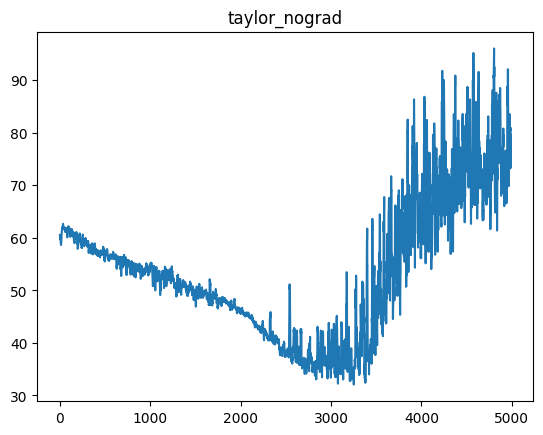

In [15]:
plt.plot(
    moving_average(
        algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.cache.grad_norm
    ),
)
plt.title("taylor_nograd")

Text(0.5, 1.0, 'lanczos_nograd')

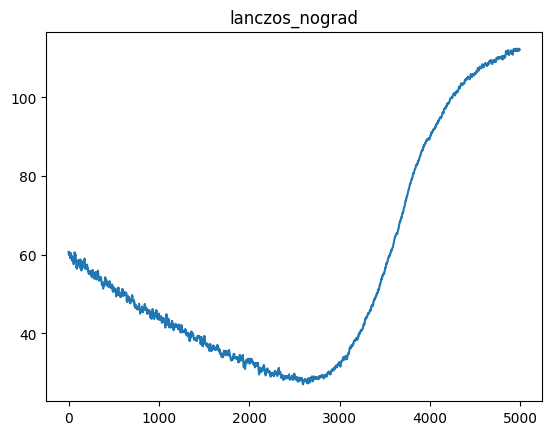

In [16]:
plt.plot(
    moving_average(
        algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.cache.grad_norm
    ),
)
plt.title("lanczos_nograd")

In [17]:
print_log(log)


dim=8, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.513984       0.261027        0.453840
ess_conf_sigma     0.005119       0.011942        0.011946
tv_mean            0.006937       0.008591        0.007074
tv_conf_sigma      0.000836       0.000988        0.000795
runtime          162.206427     248.754778      267.311623
chains_kept       30.000000      30.000000       30.000000

dim=16, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.788382       0.545581        0.346348
ess_conf_sigma     0.005597       0.035193        0.008399
tv_mean            0.014480       0.008804        0.009077
tv_conf_sigma      0.002614       0.001055        0.001052
runtime          159.398611     249.373696      267.118730
chains_kept       30.000000      30.000000       30.000000

dim=32, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         

In [18]:
print_log(log)


dim=8, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.513984       0.261027        0.453840
ess_conf_sigma     0.005119       0.011942        0.011946
tv_mean            0.006937       0.008591        0.007074
tv_conf_sigma      0.000836       0.000988        0.000795
runtime          162.206427     248.754778      267.311623
chains_kept       30.000000      30.000000       30.000000

dim=16, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.788382       0.545581        0.346348
ess_conf_sigma     0.005597       0.035193        0.008399
tv_mean            0.014480       0.008804        0.009077
tv_conf_sigma      0.002614       0.001055        0.001052
runtime          159.398611     249.373696      267.118730
chains_kept       30.000000      30.000000       30.000000

dim=32, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         

In [19]:
print_log(log)


dim=8, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.513984       0.261027        0.453840
ess_conf_sigma     0.005119       0.011942        0.011946
tv_mean            0.006937       0.008591        0.007074
tv_conf_sigma      0.000836       0.000988        0.000795
runtime          162.206427     248.754778      267.311623
chains_kept       30.000000      30.000000       30.000000

dim=16, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.788382       0.545581        0.346348
ess_conf_sigma     0.005597       0.035193        0.008399
tv_mean            0.014480       0.008804        0.009077
tv_conf_sigma      0.002614       0.001055        0.001052
runtime          159.398611     249.373696      267.118730
chains_kept       30.000000      30.000000       30.000000

dim=32, dist=toeplitz_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean         

In [20]:
plt.plot(log[0]["hist_data"][dimension][alg]["cache"].grad_norm)

NameError: name 'dimension' is not defined

In [ ]:

plt.figure(figsize=(10, 6))
window = 100  # adjust as needed

for dimension in dimensions:
    for alg in algs:
        raw = log[0]["hist_data"][dimension][alg]["cache"].accept_prob_hist
        smoothed = moving_average(np.array(raw), window_size=window)
        label = f"{alg} (dim={dimension})"
        plt.plot(smoothed, label=label, alpha=0.8)

plt.xlabel("Iteration")
plt.ylabel("Smoothed Acceptance Probability")
plt.title(f"Moving Average (window={window}) of Acceptance Probabilities")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))
window = 100  # adjust as needed

for dimension in dimensions:
    for alg in algs:
        raw = log[0]["hist_data"][dimension][alg]["cache"].accept_prob_hist
        smoothed = moving_average(np.array(raw), window_size=window)
        label = f"{alg} (dim={dimension})"
        plt.plot(smoothed, label=label, alpha=0.8)

plt.xlabel("Iteration")
plt.ylabel("Smoothed Acceptance Probability")
plt.title(f"Moving Average (window={window}) of Acceptance Probabilities")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
dim_stat = {}
for dimension in tqdm.notebook.tqdm(dimensions):
    df = []
    for alg in tqdm.notebook.tqdm(algs):
        df.append(
            BenchmarkUtils.compute_metrics(
                hist_data[dimension][alg][0].samples,
                hist_data[dimension][alg][0].true_samples,
            )
        )
        df[-1]["runtime"] = pure_runtime[dimension][alg]
    df = pd.DataFrame(df)
    df = df.T
    df.columns = list(algs.keys())

    dim_stat[dimension] = df
    print(f"dim={dimension}", df)

In [ ]:
algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.params.lf_step_size

In [ ]:
algs["hmc_vanilla"].pipeline.sample_blocks[-1]

In [ ]:
BenchmarkUtils.create_plot(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
print(f"{' ' * 30}HMC")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][100]["hmc_vanilla"]["cache"].samples[:, :, :],
    log[0]["hist_data"][100]["hmc_vanilla"]["cache"].true_samples,
)

In [ ]:
print(f"{' ' * 30}HMC Taylor")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][32]["taylor_nograd"]["cache"].samples[:, :, :],
    log[0]["hist_data"][32]["taylor_nograd"]["cache"].true_samples,
)

In [ ]:
print(f"{' ' * 30}HMC Lanczos")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][32]["lanczos_nograd"]["cache"].samples[:, :, :],
    log[0]["hist_data"][32]["lanczos_nograd"]["cache"].true_samples,
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [2], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [2], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[0].iteration.cache.samples[:, [2], :],
    algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [1], :],
    algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
tv_threshold = 0.05

In [ ]:
pure_runtime

In [ ]:
runtime

In [ ]:
fig, axes = plt.subplots(
    nrows=len(dimensions),
    ncols=2,
    figsize=(13, 4 * len(dimensions),)
)
fig.suptitle(
    f"at most {tail_count_cap} last samples, burn-in={burn_in_iter_count}, "
    f"chain_count={chain_count}, "
    f"TV threshold={tv_threshold}\n" +
    f"mixture of {gaussian_count} gaussians with "
    "random means and covariance matrices"
)

for dim_ind in range(len(dimensions)):
    for alg_ind, alg in enumerate(algs.keys()):

        ticks_count = len(hist_data[dimensions[dim_ind]][alg][1])
        xticks = probe_period * jnp.arange(1, ticks_count + 1)

        axes[dim_ind, alg_ind].plot(
            xticks,
            [
                entry["tv_mean"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            label="TV mean"
        )
        axes[dim_ind, alg_ind].fill_between(
            xticks,
            [
                entry["tv_mean"] - 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            [
                entry["tv_mean"] + 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            alpha=0.1,
            label="95% CI"
        )
        axes[dim_ind, alg_ind].axhline(tv_threshold, color="r", linestyle="dashed")
        axes[dim_ind, alg_ind].set_title(f"{alg}, dim={dimensions[dim_ind]}")
        if dim_ind + 1 == len(dimensions):
            axes[dim_ind, alg_ind].set_xlabel("iteration")
        axes[dim_ind, alg_ind].set_ylabel("TV")
        axes[dim_ind, alg_ind].legend()

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.params.sigma_prec

In [ ]:
algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.params.penalty_weight.squeeze()

In [ ]:
prec = algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.params.prec[1].detach().numpy()
minv = prec @ prec.T

In [ ]:
prec = algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T

In [ ]:
algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[1].iteration.params.lf_step_size

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[0].iteration.params.lf_step_size

In [ ]:
minv

In [ ]:
prec = algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
diff = minv - minv_l

In [ ]:
plt.hist(diff[range(len(diff)), range(len(diff))])

In [ ]:
prec = algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
prec = algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv_l = prec @ prec.T
plt.imshow(minv_l)

In [ ]:
minv_l

In [ ]:
prec = algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.prec[19].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
minv

In [ ]:
prec = algs["hmcadaptive_noent"].pipeline.sample_blocks[-1].iteration.cache.prec[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

### Reference

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)